In [2]:
%matplotlib inline
import nengo
import numpy as np
import pylab
import nengo_spa as spa

First, let's make a random binding network.  We use the same structure as the circular convolution network: a hidden layer optimized to do pairwise products, and linear transforms into and out of it.  But, instead of using the DFT matrix, we randomly generate the matrices.

In [282]:
D = 16
D_bind = 32
scaling_fudge_factor = 2.0

model = spa.Network()
model.config[nengo.Ensemble].neuron_type=nengo.LIFRate()
with model:
    in1 = spa.State(D)
    in2 = spa.State(D)
    out = spa.State(D)
    bind = nengo.networks.Product(n_neurons=50, dimensions=D_bind)
    
    T1 = np.random.normal(size=(D_bind, D))
    T2 = np.random.normal(size=(D_bind, D))
    T3 = np.random.normal(size=(D, D_bind))
    T1 = T1 / np.linalg.norm(T1, axis=1)[:, None]*np.sqrt(D)
    T2 = T2 / np.linalg.norm(T2, axis=1)[:, None]*np.sqrt(D)
    T3 = T3 / np.linalg.norm(T3, axis=1)[:, None]*scaling_fudge_factor/np.sqrt(D)
    
    nengo.Connection(in1.output, bind.input_a, transform=T1)
    nengo.Connection(in2.output, bind.input_b, transform=T2)
    nengo.Connection(bind.output, out.input, transform=T3)
    
    p_in1 = nengo.Probe(in1.output, synapse=0.01)
    p_in2 = nengo.Probe(in2.output, synapse=0.01)
    p_bind = nengo.Probe(bind.output, synapse=0.01)
    p_bind_in1 = nengo.Probe(bind.input_a, synapse=0.01)
    p_out = nengo.Probe(out.output, synapse=0.01)
    
    stim1 = nengo.Node(nengo.processes.WhiteSignal(high=0.5, period=10.0, rms=1.0/np.sqrt(D)), size_out=D)
    nengo.Connection(stim1, in1.input)
    stim2 = nengo.Node(nengo.processes.WhiteSignal(high=0.5, period=10.0, rms=1.0/np.sqrt(D)), size_out=D)
    nengo.Connection(stim2, in2.input)
    

In [178]:
sim = nengo.Simulator(model)
sim.run(10)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:12.                                                 


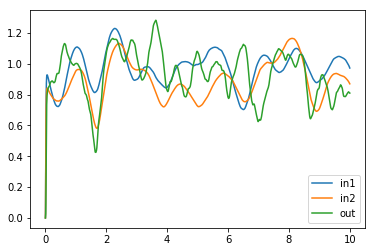

In [179]:
pylab.plot(sim.trange(), np.linalg.norm(sim.data[p_in1], axis=1), label='in1')
pylab.plot(sim.trange(), np.linalg.norm(sim.data[p_in2], axis=1), label='in2')
pylab.plot(sim.trange(), np.linalg.norm(sim.data[p_out], axis=1), label='out')
pylab.legend(loc='best')
pylab.show()

This seems to give us something like binding.  But, can we now unbind?

To do this, we build anothe binding network, feed in the bound result and one of the two inputs, and then do PES to learn the function that decodes out the other input.

In [324]:
D = 2
D_bind = 16
scaling_fudge_factor = 2.0
T = 500.0

learning_rate = 1e-5 / D_bind

model = spa.Network()
model.config[nengo.Ensemble].neuron_type=nengo.LIFRate()
with model:
    in1 = spa.State(D, subdimensions=D)
    in2 = spa.State(D, subdimensions=D)
    out = spa.State(D, subdimensions=D)
    bind = nengo.networks.Product(n_neurons=50, dimensions=D_bind)
    unbind = nengo.networks.Product(n_neurons=50, dimensions=D_bind)
    unbind_out = nengo.Node(None, size_in=D)
    error = nengo.Node(None, size_in=D)
    
    T1 = np.random.normal(size=(D_bind, D))
    T2 = np.random.normal(size=(D_bind, D))
    T3 = np.random.normal(size=(D, D_bind))
    T1 = T1 / np.linalg.norm(T1, axis=1)[:, None]*np.sqrt(D)
    T2 = T2 / np.linalg.norm(T2, axis=1)[:, None]*np.sqrt(D)
    T3 = T3 / np.linalg.norm(T3, axis=1)[:, None]*scaling_fudge_factor/np.sqrt(D)
    
    nengo.Connection(in1.output, bind.input_a, transform=T1)
    nengo.Connection(in2.output, bind.input_b, transform=T2)
    nengo.Connection(bind.output, out.input, transform=T3)
    
    
    T4 = np.random.normal(size=(D_bind, D))
    T5 = np.random.normal(size=(D_bind, D))
    T4 = T4 / np.linalg.norm(T4, axis=1)[:, None]*np.sqrt(D)
    T5 = T5 / np.linalg.norm(T5, axis=1)[:, None]*np.sqrt(D)
    nengo.Connection(out.output, unbind.input_a, transform=T4)
    nengo.Connection(in2.output, unbind.input_b, transform=T5)
    for ens in unbind.all_ensembles:
        c = nengo.Connection(ens, unbind_out, learning_rule_type=nengo.PES(learning_rate=learning_rate),
                             function=lambda x: np.zeros(D))
        nengo.Connection(error, c.learning_rule)
    nengo.Connection(unbind_out, error)
    nengo.Connection(in1.output, error, transform=-1)
        
    p_in1 = nengo.Probe(in1.output, synapse=0.01)
    p_error = nengo.Probe(error, synapse=0.01)
    p_unbind_out = nengo.Probe(unbind_out, synapse=0.01)
    
    stim1 = nengo.Node(nengo.processes.WhiteSignal(high=0.5, period=T, rms=1.0/np.sqrt(D)), size_out=D)
    nengo.Connection(stim1, in1.input)
    stim2 = nengo.Node(nengo.processes.WhiteSignal(high=0.5, period=T, rms=1.0/np.sqrt(D)), size_out=D)
    nengo.Connection(stim2, in2.input)
    

In [325]:
sim = nengo.Simulator(model)
sim.run(T)

Building finished in 0:00:01.                                                   
Simulating finished in 0:20:46.                                                 


Here are the norms of the vectors, just to make sure we're in the right ranges

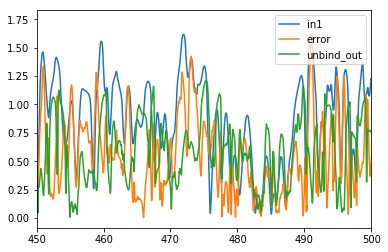

In [333]:
pylab.plot(sim.trange(), np.linalg.norm(sim.data[p_in1], axis=1), label='in1')
pylab.plot(sim.trange(), np.linalg.norm(sim.data[p_error], axis=1), label='error')
pylab.plot(sim.trange(), np.linalg.norm(sim.data[p_unbind_out], axis=1), label='unbind_out')
pylab.legend(loc='best')
pylab.xlim(450,500)
pylab.show()

Here's one of the dimensions plotted at various points in the learning process

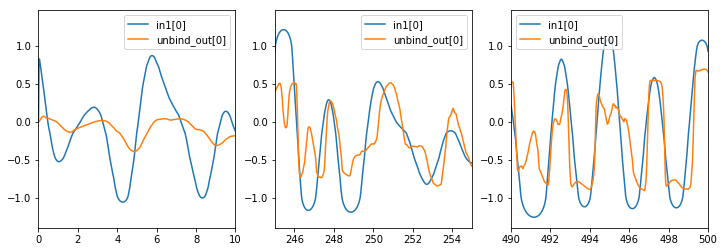

In [327]:
i = 0
T_window = 10

pylab.figure(figsize=(12,4))
pylab.subplot(1, 3, 1)
pylab.plot(sim.trange(), sim.data[p_in1][:,i], label='in1[%d]'%i)
pylab.plot(sim.trange(), sim.data[p_unbind_out][:,i], label='unbind_out[%d]'%i)
pylab.legend(loc='best')
pylab.xlim(0,T_window)
pylab.subplot(1, 3, 2)
pylab.plot(sim.trange(), sim.data[p_in1][:,i], label='in1[%d]'%i)
pylab.plot(sim.trange(), sim.data[p_unbind_out][:,i], label='unbind_out[%d]'%i)
pylab.legend(loc='best')
pylab.xlim((T-T_window)/2,(T+T_window)/2)
pylab.subplot(1, 3, 3)
pylab.plot(sim.trange(), sim.data[p_in1][:,i], label='in1[%d]'%i)
pylab.plot(sim.trange(), sim.data[p_unbind_out][:,i], label='unbind_out[%d]'%i)
pylab.legend(loc='best')
pylab.xlim(T-T_window,T)
pylab.show()


And here's the cosine of the angle between the output and the ideal output

c:\users\terry\py3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\terry\py3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


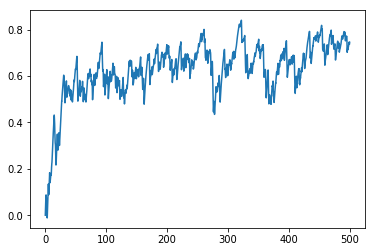

In [332]:
ideal = sim.data[p_in1]
actual = sim.data[p_unbind_out]
ideal = ideal / np.linalg.norm(ideal, axis=1)[:,None]
actual = actual / np.linalg.norm(actual, axis=1)[:,None]
prod = ideal*actual
cos_a = np.sum(prod, axis=1)
cos_a[np.isnan(cos_a)] = 0
pylab.plot(sim.trange(), nengo.synapses.Lowpass(10.0).filt(cos_a, dt=0.001))
pylab.show()

It learns!   

Open questions: does this generalize to higher dimensions?  How much longer does the learning take?  Do we need backprop (or feedback alignment)?